<a href="https://colab.research.google.com/github/conorlime/CS6271/blob/main/GP%20Applied%20to%20classification%20(multiple%20runs%20%2B%20elitism).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GP Multiple runs on an arbitrary Classification Problem.

In this notebook we tackle classification with GP. It isn't that straightforward to create a notebook that is general enough to be applied to an classification problem as some will have different types. For now, we're going to focus on binary classification with numeric types, and will look at mixed types when we move to Grammatical Evolution.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Install DEAP. 

In [2]:
!pip install deap==1.3

     |████████████████████████████████| 152 kB 4.2 MB/s 


Mount our folder.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone the class repository. 

In [4]:
!git clone https://github.com/conorlime/CS6271

Cloning into 'CS6271'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 164 (delta 64), reused 16 (delta 1), pack-reused 0
Receiving objects: 100% (164/164), 2.74 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (64/64), done.


Navigate to the Utilities folder.

In [5]:
cd CS6271/Utilities/

/content/CS6271/Utilities


Import our tools. 

In [6]:
import random
import operator
import csv
import itertools
import math

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import csv
from elitism import eaSimpleWithElitism


import matplotlib.pyplot as plt

import networkx as nx



Set our Genetic Programming parameters, including the number of runs.

In [7]:
# Genetic Programming constants:
POPULATION_SIZE = 200
P_CROSSOVER = 0.9
P_MUTATION = 0.01
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10

N_RUNS = 2




Set the random seed. 

In [8]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

GP-Specific constants.

In [9]:
MIN_TREE_HEIGHT = 5
MAX_TREE_HEIGHT = 12
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Read in the data.

In [10]:
with open("../data/spambase.csv") as classificationData:
    n_rows = sum(1 for line in classificationData)
with open("../data/spambase.csv") as classificationData:
    reader = csv.reader(classificationData)
    data = list(list(float(elem) for elem in row) for row in reader)

This is a helpful function to turn numeric values into Boolean. We're going to assume that a value greater than 0 is **True** and anything else is **False**. Note that that the standard **bool** function only returns False if the value passed is zero; this is not what we want as it will bias the results to True (because it is more likely that individuals will return a number other than zero than zero itself).

In [11]:
def turnBool(pred):
    return (pred>0)

Define our fitness function. This time there's an extra step. First we get all our predictions, which will be in numeric form, then we convert them to Boolean, and only then do we evaluate the fitness.

Notice that it is safe to use **bool** on the data because we can be confident that all those numbers are either 1 or 0.

In [12]:
def evalClassification(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    #predictions = map(func,data)
    spam_samp = random.sample(data, 400)
    result = sum(turnBool(func(*mail[:57])) is bool(mail[57]) for mail in spam_samp)

    nodes, edges, labels = gp.graph(individual)
    return result, len(nodes)

Define a protected division function.

In [13]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

Add our functions and terminals. 

In [14]:
pset = gp.PrimitiveSet("MAIN", 57) # number of inputs!!!
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)

pset.addEphemeralConstant("rand101", lambda: random.random())


Create our toolbox. This is very similar to the Symbolic Regression notebook except we are using the parameters declared up above.

In [15]:
toolbox = base.Toolbox()

#creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
#creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)


toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalClassification)
#toolbox.register("select", tools.selNSGA2)
toolbox.register("select", tools.selTournament, tournsize=5)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Create our statistics. 

In [16]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

Conduct **N_RUNS** times. 

In [17]:
for r in range(0, N_RUNS):
    population = toolbox.population(n=POPULATION_SIZE)
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)   


    # Create our statistics
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    
    
    population, logbook = eaSimpleWithElitism(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof)
    
    #maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")
    meanFitnessValues, stdFitnessValues, minFitnessValues, maxFitnessValues  = logbook.chapters['fitness'].select("avg", "std", "min", "max")
    meanSizeValues, stdSizeValues, minSizeValues, maxSizeValues  = logbook.chapters['size'].select("avg", "std", "min", "max")


    # Save statistics for this run:
    avgListFitness.append(meanFitnessValues)
    stdListFitness.append(stdFitnessValues)
    minListFitness.append(minFitnessValues)
    maxListFitness.append(maxFitnessValues)
    
    avgListSize.append(meanSizeValues)
    stdListSize.append(stdSizeValues)
    minListSize.append(minSizeValues)
    maxListSize.append(maxSizeValues)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- length={}, height={}".format(len(best), best.height))
    print("-- Best Fitness = ", best.fitness.values[0])






Currently on run 0 of 2
   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max	min	nevals	std    	avg    	gen	max 	min	nevals	std    
0  	200   	209.235	0  	313	98 	200   	43.1395	415.095	0  	4325	12 	200   	775.622
1  	182   	252.68 	1  	335	168	182   	23.6042	197.695	1  	3468	8  	182   	494.988
2  	166   	266.43 	2  	335	135	166   	34.2034	161.755	2  	3459	4  	166   	448.433
3  	170   	290.825	3  	349	138	170   	34.4001	61.305 	3  	564 	10 	170   	52.9544
4  	170   	307.65 	4  	349	128	170   	31.4803	59.51  	4  	102 	22 	170   	13.4261
5  	174   	316.765	5  	349	199	174   	26.1616	65.505 	5  	112 	25 	174   	15.1944
6  	164   	317.425	6  	349	170	164   	29.8864	68.735 	6  	120 	46 	164   	12.0468
7  	168   	320.585	7  	349	198	168   	26.6933	69.945 	7  	120 	40 	168   	13.1226
8  	164   	320.925	8  

Create our graphs using the averages across all the runs. 

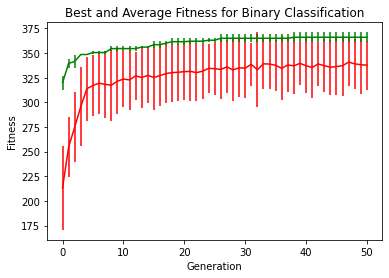

In [18]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListFitness)
stdArray = numpy.array(stdListFitness)
minArray = numpy.array(minListFitness)
maxArray = numpy.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best and Average Fitness for Binary Classification')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, maxArray.mean(0), yerr=maxArray.std(0),label="Best", color="Green")
plt.show()

Show the graph for size.

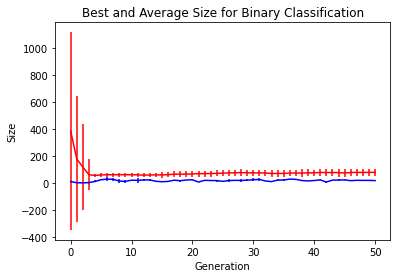

In [19]:
# Genetic Programming is done (all runs) - plot statistics:
x = numpy.arange(0, MAX_GENERATIONS+1)
avgArray = numpy.array(avgListSize)
stdArray = numpy.array(stdListSize)
minArray = numpy.array(minListSize)
maxArray = numpy.array(maxListSize)
plt.xlabel('Generation')
plt.ylabel('Size')
plt.title('Best and Average Size for Binary Classification')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Blue")
plt.show()

Roughwork from here down

In [20]:
data

[[0.0,
  0.64,
  0.64,
  0.0,
  0.32,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.64,
  0.0,
  0.0,
  0.0,
  0.32,
  0.0,
  1.29,
  1.93,
  0.0,
  0.96,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.778,
  0.0,
  0.0,
  3.756,
  61.0,
  278.0,
  1.0],
 [0.21,
  0.28,
  0.5,
  0.0,
  0.14,
  0.28,
  0.21,
  0.07,
  0.0,
  0.94,
  0.21,
  0.79,
  0.65,
  0.21,
  0.14,
  0.14,
  0.07,
  0.28,
  3.47,
  0.0,
  1.59,
  0.0,
  0.43,
  0.43,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.07,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.132,
  0.0,
  0.372,
  0.18,
  0.048,
  5.114,
  101.0,
  1028.0,
  1.0],
 [0.06,
  0.0,
  0.71,
  0.0,
  1.23,
  0.19,
  0.19,
  0.12,
  0.64,
  0.25,
  0.38,
  0.45,
  0.12,
  0.0,
  1.75,
  0.06,
  0.06,
  1.

In [21]:
ls

elitism.py  general.py  __pycache__/


In [22]:
from elitism import eaSimpleWithElitism


In [23]:
eaSimpleWithElitism()

TypeError: ignored